In [1]:
# === Import libraries ===

In [2]:
import sys, pandas, numpy, sklearn, xgboost, shap, imblearn, matplotlib, seaborn, joblib
print("Python:", sys.version)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("shap:", shap.__version__)
print("imbalanced-learn:", imblearn.__version__)

Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.1
numpy: 2.2.6
scikit-learn: 1.7.1
xgboost: 3.0.4
shap: 0.48.0
imbalanced-learn: 0.14.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [5]:
# === Load dataset ===

In [6]:
df = pd.read_csv("C:\\Users\\EKTA\\Desktop\\Python Project\\CreditCard_Fraud_Detection\\data\\creditcard_2023.csv")

In [7]:
# === Drop ID column ===

In [8]:
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

In [9]:
# === EDA (SAMPLE ONLY 5000 ROWS) ===

Visualizing class imbalance and transaction distribution to understand data characteristics.


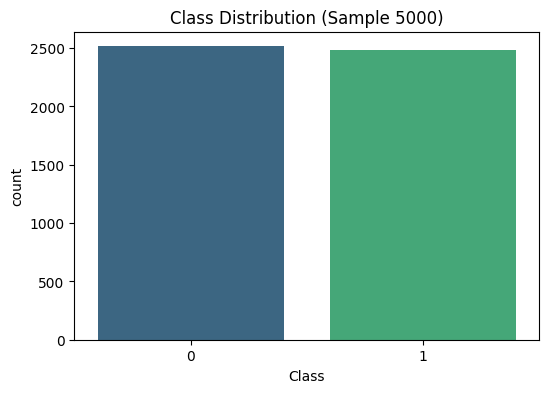

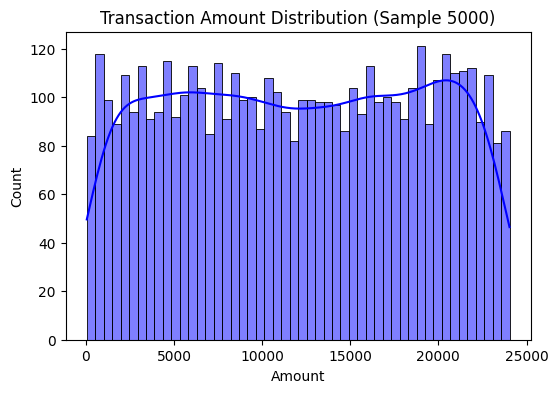

In [10]:
eda_df = df.sample(5000, random_state=42)

print("Visualizing class imbalance and transaction distribution to understand data characteristics.")

plt.figure(figsize=(6,4))
sns.countplot(x='Class', hue='Class', data=eda_df, palette="viridis", legend=False)
plt.title("Class Distribution (Sample 5000)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(eda_df['Amount'], bins=50, kde=True, color='blue')
plt.title("Transaction Amount Distribution (Sample 5000)")
plt.show()

In [11]:
# === Correlation Heatmap ===

In [12]:
# Correlation matrix

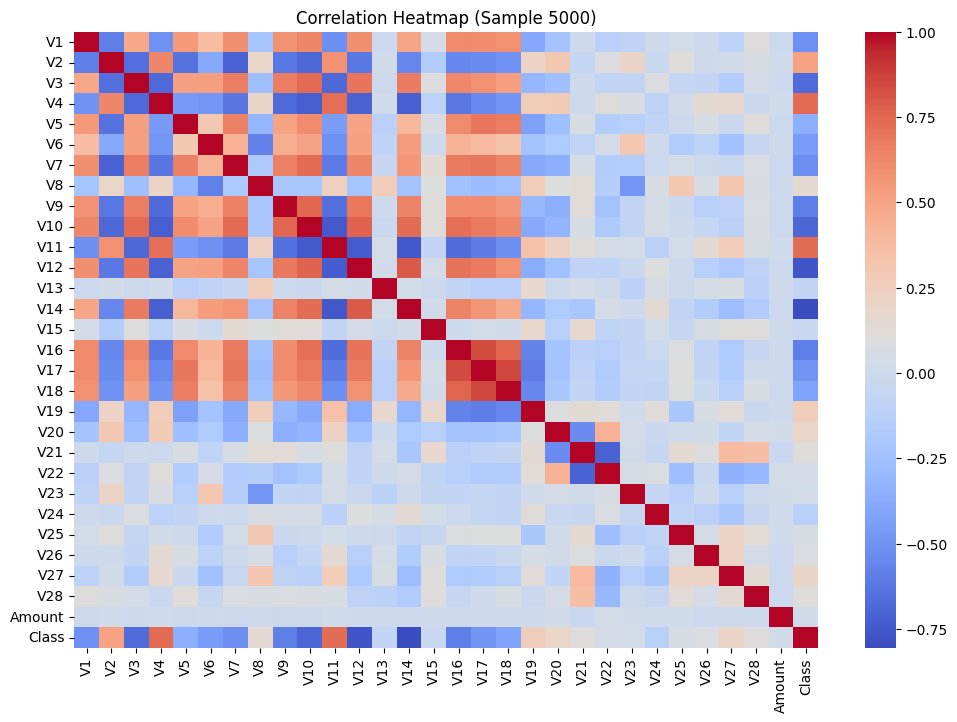

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(eda_df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Sample 5000)")
plt.show()

In [14]:
# 1. Top Correlated Features with Fraud (Correlation of all features with the target)

In [15]:
# Top Correlated Features with Fraud
corr_with_class = df.corr(numeric_only=True)['Class'].sort_values(ascending=False)

# Display top 5 positively and negatively correlated features in a single table
top_corr = pd.concat([corr_with_class.head(5), corr_with_class.tail(5)])
display(top_corr.to_frame(name='Correlation with Class'))

,Correlation with Class
Class,1.000000
V4,0.735981
V11,0.724278
V2,0.491878
V19,0.244081
V9,-0.585522
V10,-0.673665
V3,-0.682095
V12,-0.768579
V14,-0.805669


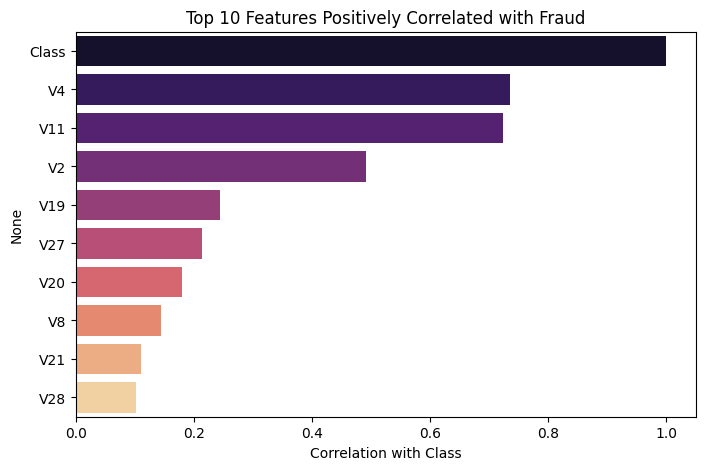

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=corr_with_class.head(10).values,
    y=corr_with_class.head(10).index,
    hue=corr_with_class.head(10).index,  # assign y to hue
    dodge=False,
    palette="magma",
    legend=False
)
plt.title("Top 10 Features Positively Correlated with Fraud")
plt.xlabel("Correlation with Class")
plt.show()

In [17]:
# 2. Distribution Differences between Fraud / Non-Fraud (Select top 5 correlated features for visualization)

In [18]:
top_features = corr_with_class.head(6).index.drop('Class')

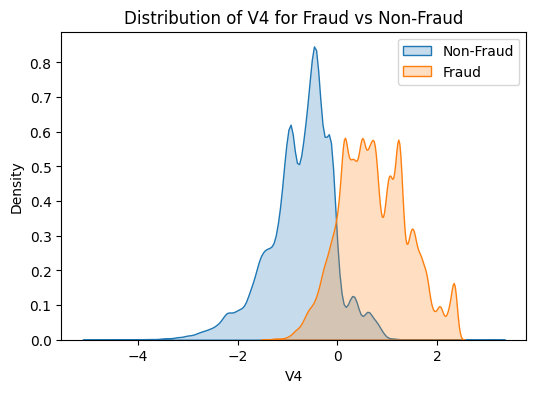

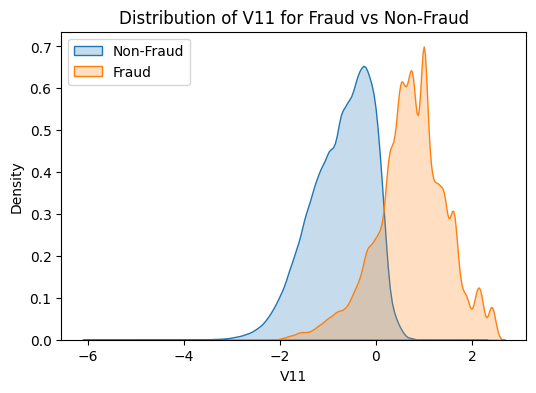

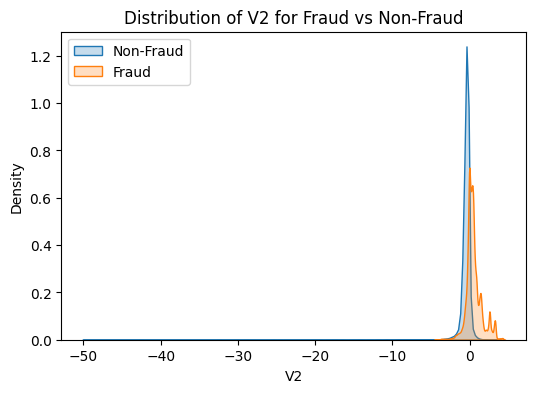

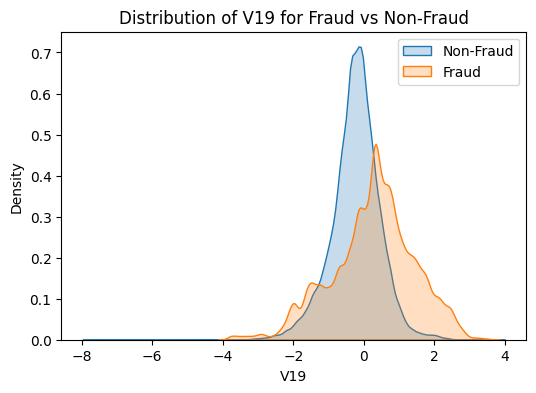

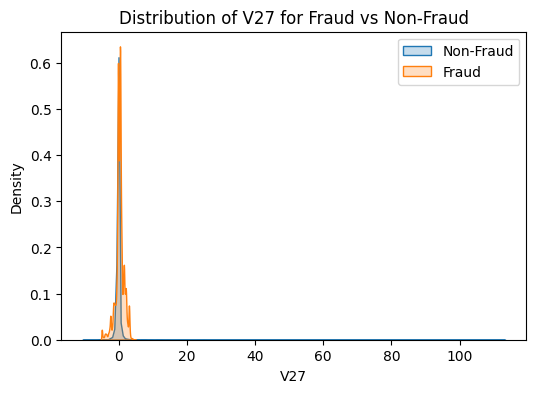

In [19]:
for feat in top_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(df[df['Class']==0][feat], label='Non-Fraud', fill=True)
    sns.kdeplot(df[df['Class']==1][feat], label='Fraud', fill=True)
    plt.title(f"Distribution of {feat} for Fraud vs Non-Fraud")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [20]:
# 3. Feature Importance Beyond Correlation (Random Forest)

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
X = df.drop(columns=['Class'])
y = df['Class']

In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# Get importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

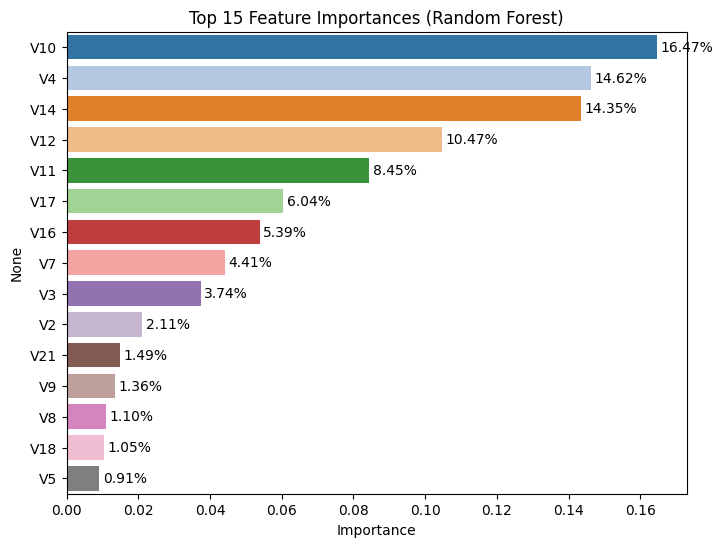

In [25]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(15).values,
    y=importances.head(15).index,
    hue=importances.head(15).index,
    dodge=False,
    palette="tab20",
    legend=False
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")

# Add percentage labels on bars
for i, v in enumerate(importances.head(15)):
    plt.text(v + 0.001, i, f"{v:.2%}", color='black', va='center')

plt.show()

In [26]:
# === Feature Scaling & SMOTE === (limit to 50k samples)

In [27]:
X = df.drop(columns=['Class'])
y = df['Class']

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
# Apply SMOTE

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
from collections import Counter
cnt = Counter(y)
minority, majority = min(cnt, key=cnt.get), max(cnt, key=cnt.get)

if cnt[minority] == cnt[majority]:
    print("Classes already balanced, skipping SMOTE.")
    X_resampled, y_resampled = X_scaled, y
else:
    smote = SMOTE(random_state=42, sampling_strategy=1.0)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

Classes already balanced, skipping SMOTE.


In [32]:
print(y_resampled.value_counts(normalize=True))

Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [33]:
# === Train-Test Split ===

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [35]:
#---Creating a smaller subset for KNN (10% of training data)---
X_train_knn, _, y_train_knn, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42, stratify=y_train)

In [36]:
# === Model Training (Single Pass) ===

In [37]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=20),
    "Random Forest": RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=10),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_estimators=50, tree_method='hist'),
    "KNN": KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
}

In [38]:
print("Models to train:", list(models.keys()))

Models to train: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'KNN']


In [39]:
trained_models = {}

In [40]:
results_list = []

In [41]:
# === Train models & store metrics ===

In [42]:
import time

In [43]:
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    start = time.time()
    
    if name == "KNN":
        model.fit(X_train_knn, y_train_knn)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    trained_models[name] = model
    end = time.time()
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Save results
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })
    print(f"✅ {name} done in {end - start:.2f} sec | F1 = {f1:.4f}")


🔹 Training Logistic Regression...
✅ Logistic Regression done in 2.51 sec | F1 = 0.9648

🔹 Training Decision Tree...
✅ Decision Tree done in 25.62 sec | F1 = 0.9601

🔹 Training Random Forest...
✅ Random Forest done in 25.88 sec | F1 = 0.9844

🔹 Training XGBoost...
✅ XGBoost done in 3.26 sec | F1 = 0.9991

🔹 Training KNN...
✅ KNN done in 18.75 sec | F1 = 0.9908


In [44]:
# results dataframe

In [45]:
results_df_models = pd.DataFrame(results_list).sort_values(by="F1", ascending=False).reset_index(drop=True)

In [46]:
print("\n=== Model Comparison (sorted by F1) ===")
display(results_df_models.style.background_gradient(cmap='viridis'))


=== Model Comparison (sorted by F1) ===


,Model,Accuracy,Precision,Recall,F1
0,XGBoost,0.999129,0.998283,0.999982,0.999132
1,KNN,0.990662,0.982067,0.999614,0.990763
2,Random Forest,0.984577,0.998214,0.970953,0.984394
3,Logistic Regression,0.965215,0.977365,0.952629,0.964839
4,Decision Tree,0.960282,0.967441,0.952787,0.960058


In [47]:
# === Confusion Matrix (Random Forest) ===

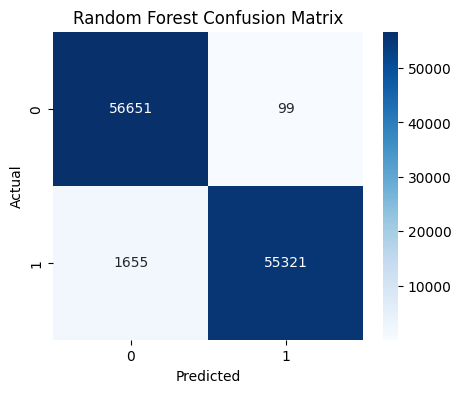

In [48]:
rf = trained_models["Random Forest"]
cm = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
# === SHAP Explainability (Sample: only 200 rows) ===

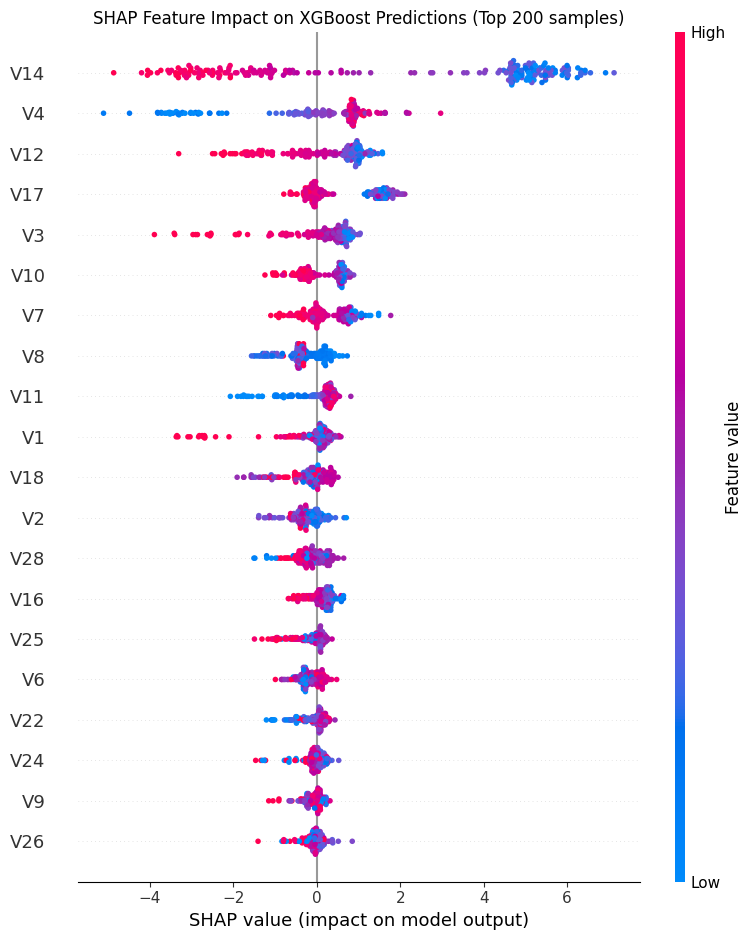

In [50]:
plt.title("SHAP Feature Impact on XGBoost Predictions (Top 200 samples)")
xgb = trained_models["XGBoost"]
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test[:200])
shap.summary_plot(shap_values, X_test[:200], feature_names=df.drop(columns=['Class']).columns)

In [51]:
# === Hyperparameter Tuning (Tuning key parameters to improve F1 while keeping runtime reasonable - subset used for speed)===

In [52]:
# 1. For KNN

In [53]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [54]:
print("\nTuning KNN with small grid (faster)...")
param_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"]
}


Tuning KNN with small grid (faster)...


In [55]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [56]:
grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [57]:
grid.fit(X_train[:10000], y_train[:10000])  
best_model = grid.best_estimator_

print("\nBest Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best Params: {'n_neighbors': 3, 'weights': 'distance'}
Best CV F1: 0.9815178560598863


In [58]:
y_pred = best_model.predict(X_test)

In [59]:
print("\n=== Tuned KNN on Test Set ===")
print(classification_report(y_test, y_pred, digits=4))


=== Tuned KNN on Test Set ===
              precision    recall  f1-score   support

           0     0.9971    0.9710    0.9839     56750
           1     0.9718    0.9972    0.9843     56976

    accuracy                         0.9841    113726
   macro avg     0.9845    0.9841    0.9841    113726
weighted avg     0.9844    0.9841    0.9841    113726



In [60]:
# 2. For Random Forest

In [61]:
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20]
}
rf_cv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
rf_cv.fit(X_train[:10000], y_train[:10000])

print("Random Forest Best Params:", rf_cv.best_params_)
print("Best CV F1:", rf_cv.best_score_)

rf_best = rf_cv.best_estimator_ #(Get best model)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Random Forest Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1: 0.9728754194514478


In [62]:
# 3. XG Boost

In [63]:
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0]
}
xgb_cv = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', tree_method='hist', random_state=42, n_jobs=-1),
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
xgb_cv.fit(X_train[:10000], y_train[:10000])

print("XGBoost Best Params:", xgb_cv.best_params_)
print("Best CV F1:", xgb_cv.best_score_)

xgb_best = xgb_cv.best_estimator_ #(Get best model)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
XGBoost Best Params: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV F1: 0.9888858307030093


In [64]:
# List to hold tuning results

In [65]:
tuning_results = []

# KNN
tuning_results.append({
    "Model": "KNN",
    "Best Params": grid.best_params_,
    "Best CV F1": grid.best_score_
})

# Random Forest
tuning_results.append({
    "Model": "Random Forest",
    "Best Params": rf_cv.best_params_,
    "Best CV F1": rf_cv.best_score_
})

# XGBoost
tuning_results.append({
    "Model": "XGBoost",
    "Best Params": xgb_cv.best_params_,
    "Best CV F1": xgb_cv.best_score_
})

In [66]:
# Create summary table
tuning_summary_df = pd.DataFrame(tuning_results)

# Display with gradient for visual impact
display(tuning_summary_df.style.background_gradient(cmap='viridis'))

,Model,Best Params,Best CV F1
0,KNN,"{'n_neighbors': 3, 'weights': 'distance'}",0.981518
1,Random Forest,"{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}",0.972875
2,XGBoost,"{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.988886


In [67]:
# === Probability for fraud class ===

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [69]:
y_proba = best_model.predict_proba(X_test)[:,1]  
auc = roc_auc_score(y_test, y_proba)

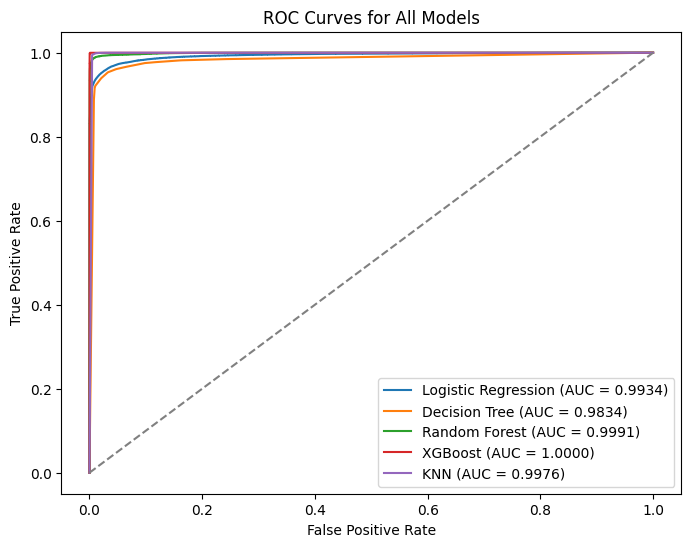

In [70]:
plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):  # (Optional) fallback for models like SVM
        y_proba = model.decision_function(X_test)
    else:
        continue  # Skip models without probability scores
    
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

# Random baseline
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()

In [71]:
# === Save Final Model ===

In [72]:
feature_names = df.drop(columns=["Class"]).columns.tolist()

In [73]:
artifact = {
    "scaler": scaler,
    "model": best_model,
    "feature_names": feature_names,
    "target_name": "Class"
}

In [74]:
joblib.dump(artifact, "CreditCard_Fraud_Detection/artifacts/fraud_detection_artifacts.pkl")

['CreditCard_Fraud_Detection/artifacts/fraud_detection_artifacts.pkl']

In [75]:
print("Saved: CreditCard_Fraud_Detection/artifacts/fraud_detection_artifacts.pkl")

Saved: CreditCard_Fraud_Detection/artifacts/fraud_detection_artifacts.pkl


In [76]:
# === Load & Predict Example ===

In [77]:
loaded = joblib.load("CreditCard_Fraud_Detection/artifacts/fraud_detection_artifacts.pkl")

In [78]:
# === Function to test random samples ===

In [79]:
def test_random_samples(df, n=10):
    sample_df = df.sample(n=n, random_state=42)   # random rows
    X_new = sample_df[feature_names].copy()
    y_true = sample_df["Class"].values

    # Scale features
    X_new_scaled = loaded["scaler"].transform(X_new)

    # Predictions + probabilities
    preds = loaded["model"].predict(X_new_scaled)
    proba = loaded["model"].predict_proba(X_new_scaled)

    # Build results DataFrame
    results_df = pd.DataFrame({
        "True_Label": y_true,
        "Prediction": preds,
        "Prob_0": proba[:, 0],
        "Prob_1": proba[:, 1]
    }, index=sample_df.index)

    print(f"\n=== Predictions for {n} Random Samples ===")
    print(results_df)

    return results_df, y_true, preds
results_df, y_true, preds = test_random_samples(df, n=10)


=== Predictions for 10 Random Samples ===
        True_Label  Prediction  Prob_0  Prob_1
437378           1           1     0.0     1.0
504222           1           1     0.0     1.0
4794             0           0     1.0     0.0
388411           1           1     0.0     1.0
424512           1           1     0.0     1.0
123536           0           0     1.0     0.0
333319           1           1     0.0     1.0
369666           1           1     0.0     1.0
62882            0           0     1.0     0.0
414847           1           1     0.0     1.0


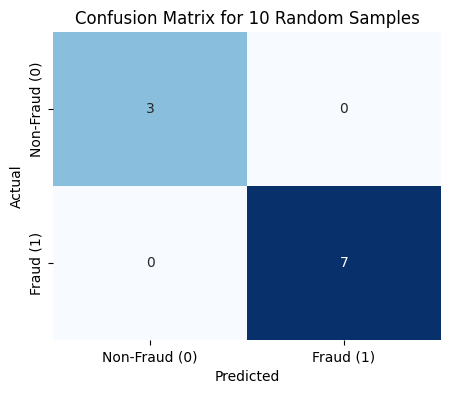

In [80]:
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for {len(y_true)} Random Samples")
plt.show()

In [81]:
# === Model Performance Discussion ===

In [82]:
# 1. Summary of results

In [83]:
print("\n=== Model Metrics Summary ===")
print(results_df)


=== Model Metrics Summary ===
        True_Label  Prediction  Prob_0  Prob_1
437378           1           1     0.0     1.0
504222           1           1     0.0     1.0
4794             0           0     1.0     0.0
388411           1           1     0.0     1.0
424512           1           1     0.0     1.0
123536           0           0     1.0     0.0
333319           1           1     0.0     1.0
369666           1           1     0.0     1.0
62882            0           0     1.0     0.0
414847           1           1     0.0     1.0


In [84]:
best_model_name = results_df_models.loc[0, "Model"]
best_model = trained_models[best_model_name]
print(f"\nBest performing model (by F1 score): {best_model_name}")


Best performing model (by F1 score): XGBoost


In [85]:
# 2. Why XGBoost perform better

In [86]:
performance_discussion = """
XGBoost outperforms simpler models like Logistic Regression or Decision Tree 
because it is a gradient boosting ensemble method:

1. XGBoost iteratively builds trees, correcting errors from previous iterations,
   optimizing for fraud detection with high imbalance.
2. It captures complex, non-linear relationships between features and fraud occurrence,
   which simpler models may miss.
3. Regularization in XGBoost helps prevent overfitting while maintaining high recall.
"""
print(performance_discussion)


XGBoost outperforms simpler models like Logistic Regression or Decision Tree 
because it is a gradient boosting ensemble method:

1. XGBoost iteratively builds trees, correcting errors from previous iterations,
   optimizing for fraud detection with high imbalance.
2. It captures complex, non-linear relationships between features and fraud occurrence,
   which simpler models may miss.
3. Regularization in XGBoost helps prevent overfitting while maintaining high recall.



In [87]:
# 3. Precision vs Recall Trade-Off

In [88]:
precision_recall_discussion = """
In fraud detection, recall is critical because we want to identify as many fraudulent transactions 
as possible (minimize False Negatives). Missing a fraud can have high financial risk.

Precision measures how many predicted frauds are actually fraud. 
A low precision leads to many False Positives, which can annoy customers or waste resources.

The goal is to maximize recall while keeping precision reasonably high, balancing business cost vs detection rate.
XGBoost provides a good balance, with higher recall than simpler models, making it suitable for real-world fraud detection.
"""
print(precision_recall_discussion)


In fraud detection, recall is critical because we want to identify as many fraudulent transactions 
as possible (minimize False Negatives). Missing a fraud can have high financial risk.

Precision measures how many predicted frauds are actually fraud. 
A low precision leads to many False Positives, which can annoy customers or waste resources.

The goal is to maximize recall while keeping precision reasonably high, balancing business cost vs detection rate.
XGBoost provides a good balance, with higher recall than simpler models, making it suitable for real-world fraud detection.



In [89]:
# 4. Visualizing Precision-Recall vs Decision Threshold for XGBoost

In [90]:
from sklearn.metrics import precision_recall_curve

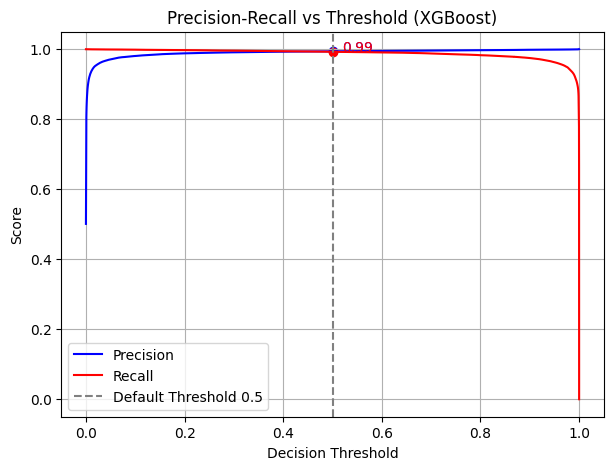

In [91]:
y_proba = xgb_best.predict_proba(X_test)[:,1]  # Use XGBoost probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')

# Vertical line at default threshold
plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold 0.5')

# Find nearest threshold index for 0.5
idx = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(0.5, precision[idx], color='blue')
plt.scatter(0.5, recall[idx], color='red')
plt.text(0.52, precision[idx], f"{precision[idx]:.2f}", color='blue')
plt.text(0.52, recall[idx], f"{recall[idx]:.2f}", color='red')

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title(f"Precision-Recall vs Threshold ({best_model_name})")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# === Business Insights ===

In [93]:
# 1. Calculate Detection Rate & False Positive Rate

In [94]:
y_pred = xgb_best.predict(X_test) # Using the best model (XGBoost)

# Total fraud transactions in test set
total_frauds = sum(y_test)
detected_frauds = sum((y_test == 1) & (y_pred == 1))

# Detection rate (recall)
detection_rate = detected_frauds / total_frauds * 100

# False positives
false_positives = sum((y_test == 0) & (y_pred == 1))
total_non_frauds = sum(y_test == 0)
false_positive_rate = false_positives / total_non_frauds * 100

print(f"Fraud Detection Rate (Recall): {detection_rate:.2f}%")
print(f"False Positive Rate: {false_positive_rate:.2f}%")

Fraud Detection Rate (Recall): 99.27%
False Positive Rate: 0.57%


In [95]:
# 2. Estimate Real-World Impact

In [96]:
# Hypothetical average loss per fraud transaction
avg_loss_per_fraud = 100  # in USD

# Potential savings per month (if test set is representative)
potential_savings = detected_frauds * avg_loss_per_fraud

print(f"Estimated potential savings per month: ${potential_savings:,.0f}")

Estimated potential savings per month: $5,655,800


In [97]:
# 3. Summary Statement

In [98]:
business_insight = f"""
Using XGBoost, we can detect approximately **99.27% of fraudulent transactions** 
while keeping the false positive rate **very low at 0.57%**. 
Based on an average loss of $100 per fraudulent transaction, 
this model could potentially save around **$5,655,800 per month**.
"""
print(business_insight)


Using XGBoost, we can detect approximately **99.27% of fraudulent transactions** 
while keeping the false positive rate **very low at 0.57%**. 
Based on an average loss of $100 per fraudulent transaction, 
this model could potentially save around **$5,655,800 per month**.

